rs2525548 is on chrom 7:99553167 C>G , we use the cross validation fold with chrom 7 in test set (split 6)

In [1]:
snp='rs2525548'
split=6
snp_chrom="chr7"
snp_pos=99553167

In [2]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np 

In [3]:
from keras.models import load_model

Using TensorFlow backend.


In [4]:
import pysam
# SNP is at position 100 in the 200 bp MPRA construct 
def get_inputs(chrom,snp_pos,left_flank=99,right_flank=100,ref="/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa"):
    ref=pysam.FastaFile(ref)
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1],'N':[0,0,0,0]}
    snp_pos=snp_pos-1 #convert to 0-indexing
    left_flank=ref.fetch(chrom,snp_pos-left_flank,snp_pos)
    print(len(left_flank))
    right_flank=ref.fetch(chrom,snp_pos+1,snp_pos+right_flank+1)
    print(len(right_flank))
    encoded=dict() 
    seqs=dict()
    for base in ['A','C','G','T']: 
        curseq=left_flank+base+right_flank
        seqs[base]=curseq
        encoded[base]=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in curseq]),0),0)
    return encoded,seqs

In [5]:
##load the model 
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1

custom_objects={"sensitivity":tpr,
                "specificity":tnr,
                "fpr":fpr,
                "fnr":fnr,
                "precision":precision,
                "f1":f1}

model=load_model("v4/gecco.classification.SummitWithin200bpCenter.7",custom_objects=custom_objects)

In [6]:
#get deepLIFT function 
from deeplift.conversion import kerasapi_conversion as kc
import keras.backend as K 
deeplift_model = kc.convert_model_from_saved_files("v4/gecco.classification.SummitWithin200bpCenter."+str(split),verbose=False)

In [7]:
#get the deeplift score with respect to the logit                                                                                                                    
score_func = deeplift_model.get_target_contribs_func(
find_scores_layer_idx=0,
    target_layer_idx=-2)


In [8]:
import numpy as np 
input_references = [np.array([0.3, 0.2, 0.2, 0.3])[None, None, None, :]]

 We have the fasta sequence from "CC_pilot-MPRA.fa"

>rs2525548_A_wC
CCATGCACAGGTTTCAACCGCAAAAGACACAGCAGAGCTCTCACCTTGACCTTCTCATGAAACCTCACCTGCCTGTGTCTGTGCTTTTCCTTCCCGTGGCACAGAACTTTCCTTACATCCTGTCCTCAGCCTCCCACTCTGGATTATTCCAAAGTCCATCCTCCAAGCTGGGCTCCTTAAGGAAATCATTCCCAGCCTTC


In [9]:
mpra_seq="CCATGCACAGGTTTCAACCGCAAAAGACACAGCAGAGCTCTCACCTTGACCTTCTCATGAAACCTCACCTGCCTGTGTCTGTGCTTTTCCTTCCCGTGGCACAGAACTTTCCTTACATCCTGTCCTCAGCCTCCCACTCTGGATTATTCCAAAGTCCATCCTCCAAGCTGGGCTCCTTAAGGAAATCATTCCCAGCCTTC"

In [10]:
len(mpra_seq)

200

In [11]:
mpra_seq[99] #reference allele "C" at position 100 in the sequence , 99 bp left flank, 100 bp right flank 

'C'

In [12]:
## extract the 1kb region centered at the SNP 
X,seqs=get_inputs(snp_chrom,snp_pos)


99
100


In [13]:
X['C'].shape

(1, 1, 200, 4)

In [14]:
seqs['C']

'CCATGCACAGGTTTCAACCGCAAAAGACACAGCAGAGCTCTCACCTTGACCTTCTCATGAAACCTCACCTGCCTGTGTCTGTGCTTTTCCTTCCCGTGGCACAGAACTTTCCTTACATCCTGTCCTCAGCCTCCCACTCTGGATTATTCCAAAGTCCATCCTCCAAGCTGGGCTCCTTAAGGAAATCATTCCCAGCCTTC'

In [15]:
#verify we have extracted the same sequence that was used in the MPRA 
seqs['C'].upper()==mpra_seq.upper()

True

In [16]:
#Now, pad to 1000 bp by using a 500 bp flank 
X,seqs=get_inputs(snp_chrom,snp_pos,left_flank=499,right_flank=500)
X['C'].shape

499
500


(1, 1, 1000, 4)

In [17]:
tasks=["Healthy","Tumor","SW480","HCT116","COLO205"]

In [18]:
## pretty print
print('\t'+'\t'.join(tasks))
for base in ['A','C','G','T']:
    print(base+'\t'+'\t'.join([str(round(i,3)) for i in model.predict(X[base])[0]]))

	Healthy	Tumor	SW480	HCT116	COLO205
A	0.064	0.387	0.632	0.197	0.363
C	0.106	0.444	0.64	0.195	0.402
G	0.076	0.424	0.612	0.197	0.372
T	0.044	0.322	0.645	0.188	0.357


In [19]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores_A=dict() 
for t_index in range(5):
    dl_scores_A[tasks[t_index]]=score_func(
                        task_idx=t_index,
                        input_data_list=[X['A']],
                        batch_size=1,
                        progress_update=None,
                        input_references_list=input_references)

In [20]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores_C=dict() 
for t_index in range(5):
    dl_scores_C[tasks[t_index]]=score_func(
                        task_idx=t_index,
                        input_data_list=[X['C']],
                        batch_size=1,
                        progress_update=None,
                        input_references_list=input_references)

In [21]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores_G=dict() 
for t_index in range(5):
    dl_scores_G[tasks[t_index]]=score_func(
                        task_idx=t_index,
                        input_data_list=[X['G']],
                        batch_size=1,
                        progress_update=None,
                        input_references_list=input_references)

In [22]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores_T=dict() 
for t_index in range(5):
    dl_scores_T[tasks[t_index]]=score_func(
                        task_idx=t_index,
                        input_data_list=[X['T']],
                        batch_size=1,
                        progress_update=None,
                        input_references_list=input_references)

In [23]:
from dragonn.tutorial_utils import  plot_seq_importance

/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Healthy DeepLIFT Scores 

In [24]:
ylim=(-.25,0.25)
xlow=0
xhigh=1000

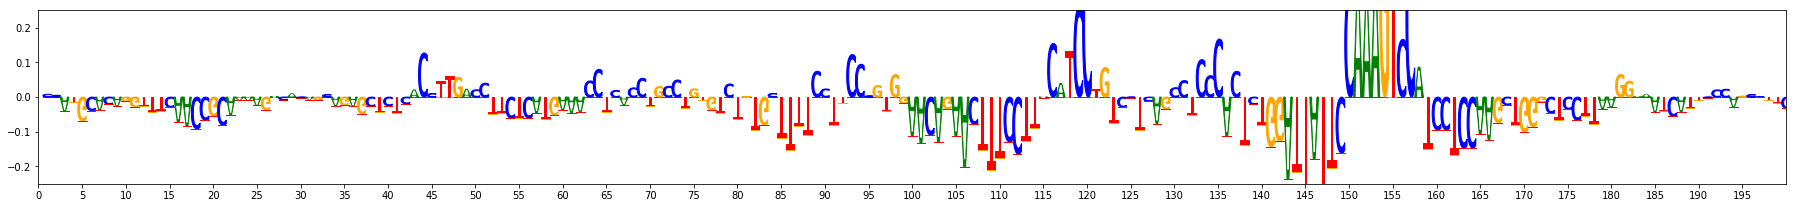

In [25]:
tmp1=dl_scores_A['Healthy'][0].squeeze()[400:600]
tmp2=X['A'].squeeze()[400:600]
plot_seq_importance(tmp1,tmp2,ylim=ylim)

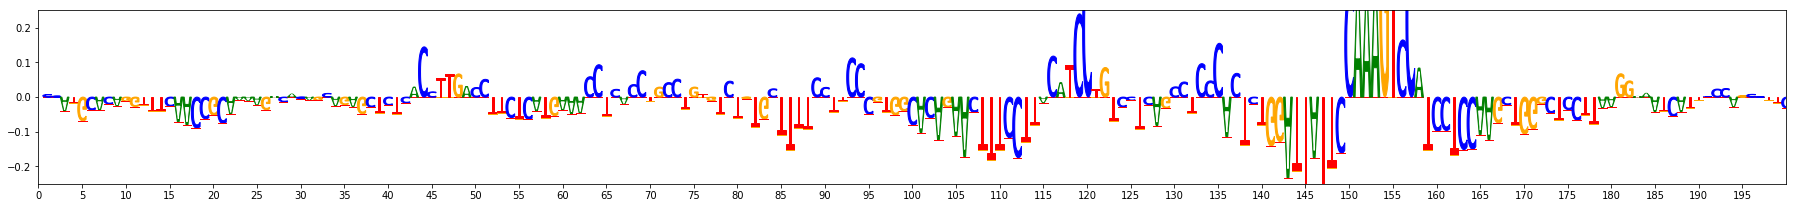

In [26]:
tmp3=dl_scores_C['Healthy'][0].squeeze()[400:600]
tmp4=X['C'].squeeze()[400:600]
plot_seq_importance(tmp3,tmp4,ylim=ylim)

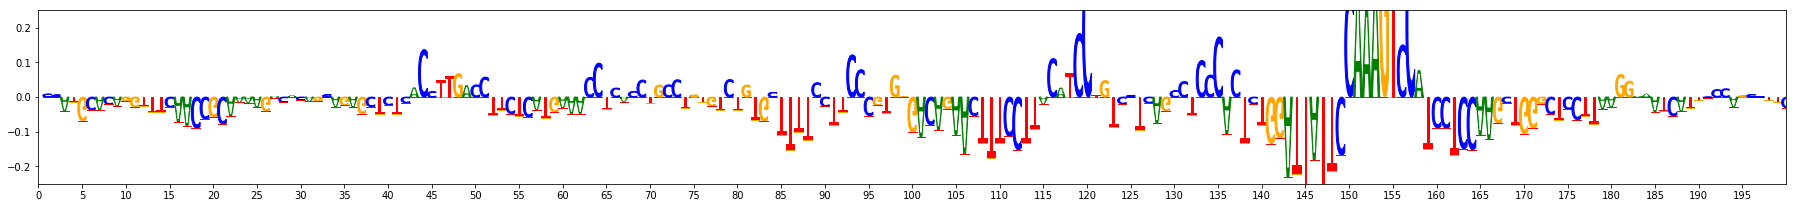

In [27]:
tmp5=dl_scores_G['Healthy'][0].squeeze()[400:600]
tmp6=X['G'].squeeze()[400:600]
plot_seq_importance(tmp5,tmp6,ylim=ylim)

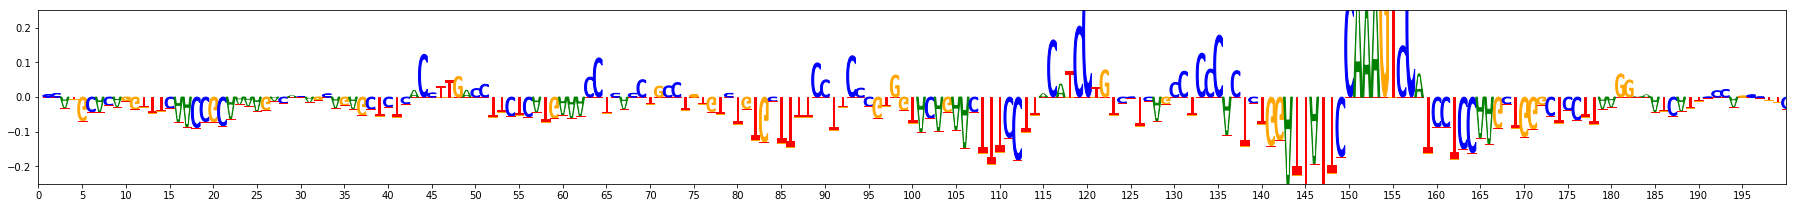

In [28]:
tmp7=dl_scores_T['Healthy'][0].squeeze()[400:600]
tmp8=X['T'].squeeze()[400:600]
plot_seq_importance(tmp7,tmp8,ylim=ylim)

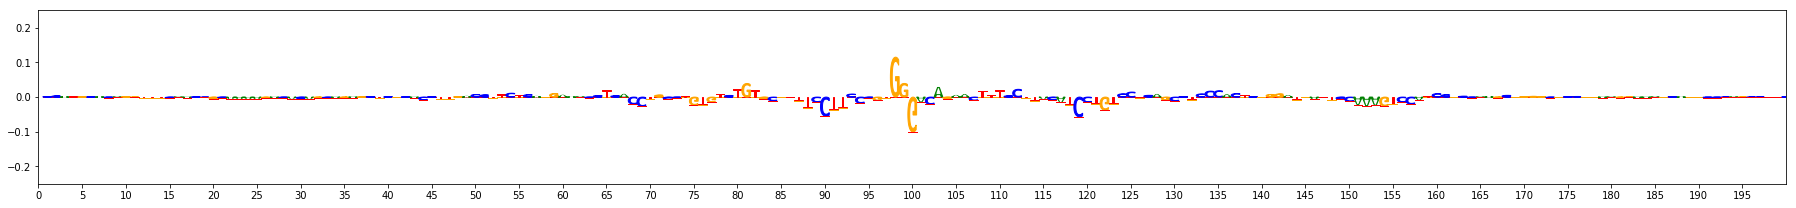

In [29]:
#delta track for the alternate G allele - reference C allele (with G at position 100)
plot_seq_importance(tmp5-tmp3,tmp6,ylim=ylim)

## Tumor

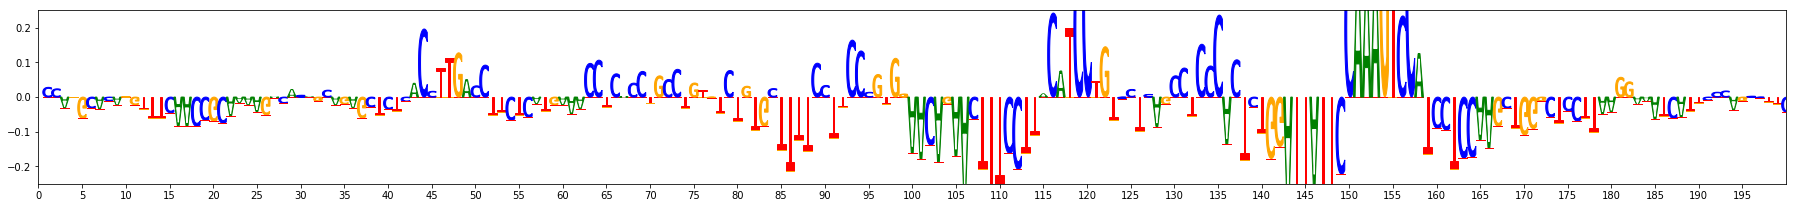

In [30]:
tmp1=dl_scores_A['Tumor'][0].squeeze()[400:600]
tmp2=X['A'].squeeze()[400:600]
plot_seq_importance(tmp1,tmp2,ylim=ylim)

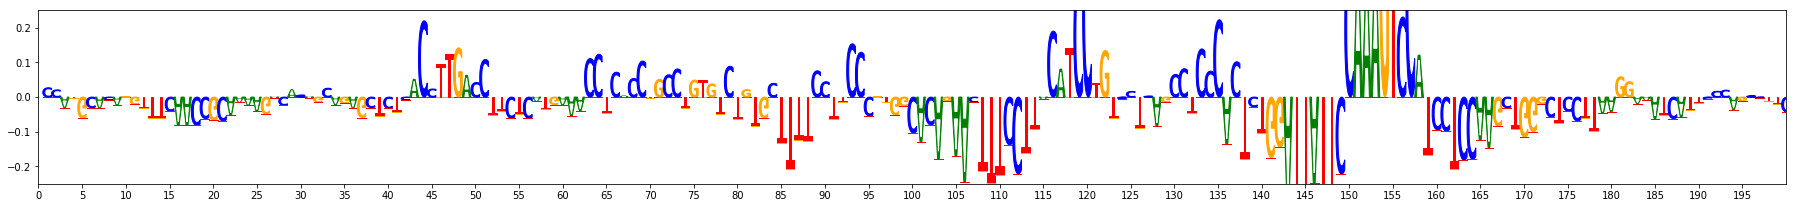

In [31]:
tmp3=dl_scores_C['Tumor'][0].squeeze()[400:600]
tmp4=X['C'].squeeze()[400:600]
plot_seq_importance(tmp3,tmp4,ylim=ylim)

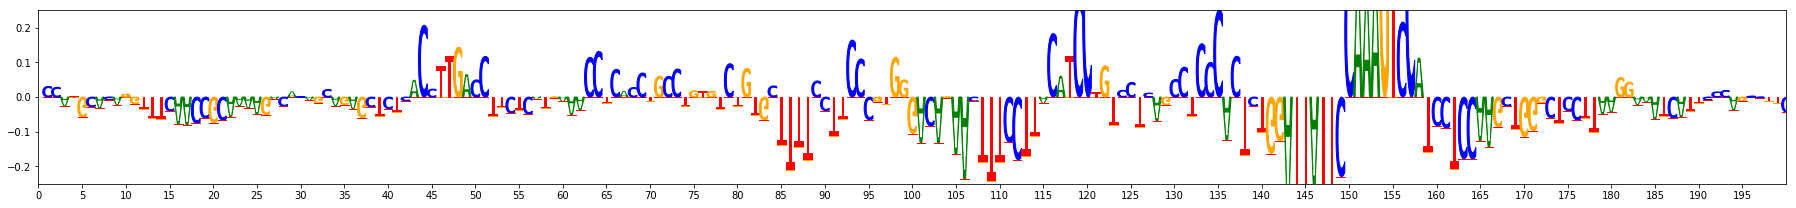

In [32]:
tmp5=dl_scores_G['Tumor'][0].squeeze()[400:600]
tmp6=X['G'].squeeze()[400:600]
plot_seq_importance(tmp5,tmp6,ylim=ylim)

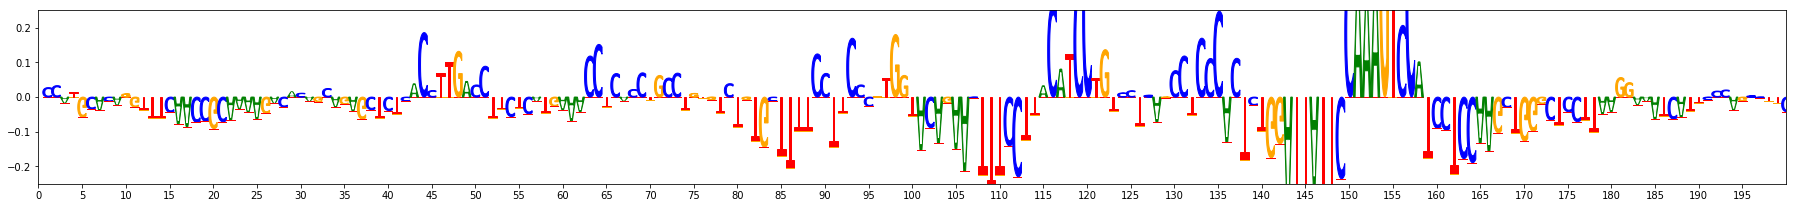

In [33]:
tmp7=dl_scores_T['Tumor'][0].squeeze()[400:600]
tmp8=X['T'].squeeze()[400:600]
plot_seq_importance(tmp7,tmp8,ylim=ylim)

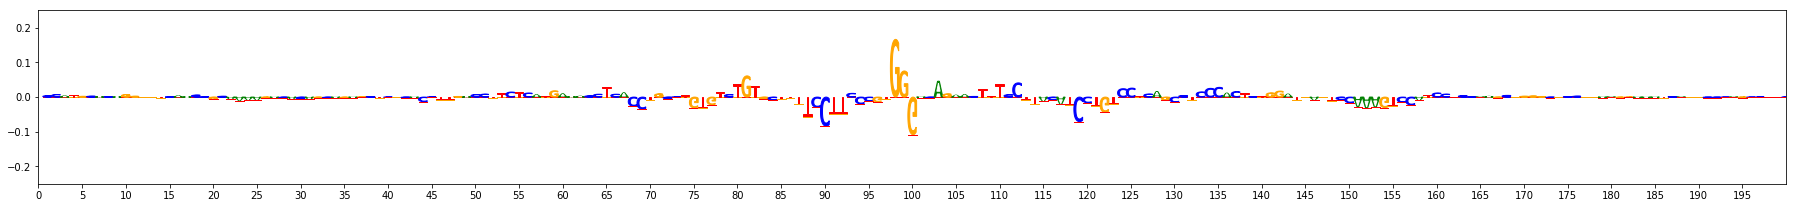

In [34]:
#delta track for the alternate G allele - reference C allele (with G at position 100)
plot_seq_importance(tmp5-tmp3,tmp6,ylim=ylim)

## SW480

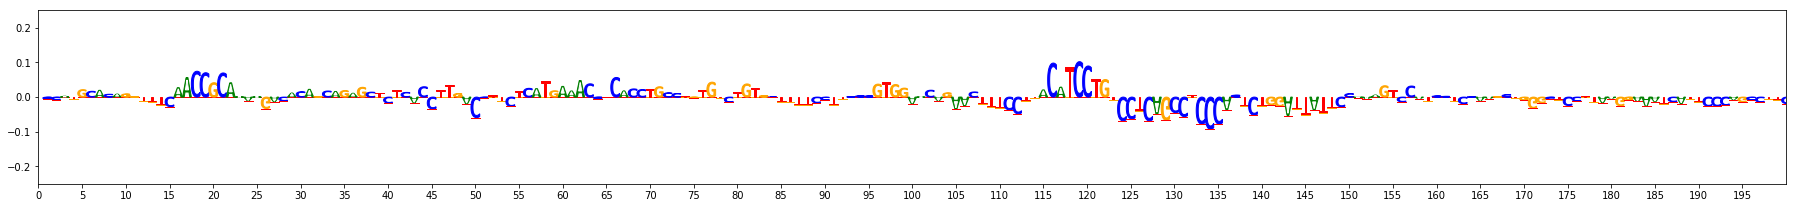

In [35]:
tmp1=dl_scores_A['SW480'][0].squeeze()[400:600]
tmp2=X['A'].squeeze()[400:600]
plot_seq_importance(tmp1,tmp2,ylim=ylim)

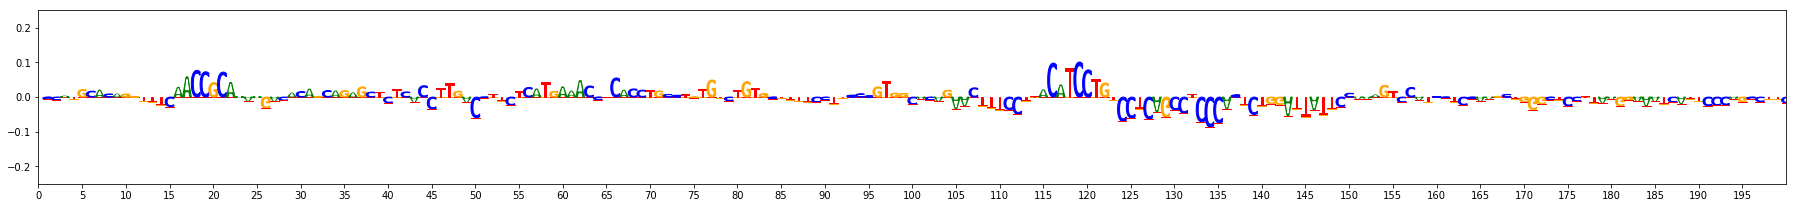

In [36]:
tmp3=dl_scores_C['SW480'][0].squeeze()[400:600]
tmp4=X['C'].squeeze()[400:600]
plot_seq_importance(tmp3,tmp4,ylim=ylim)

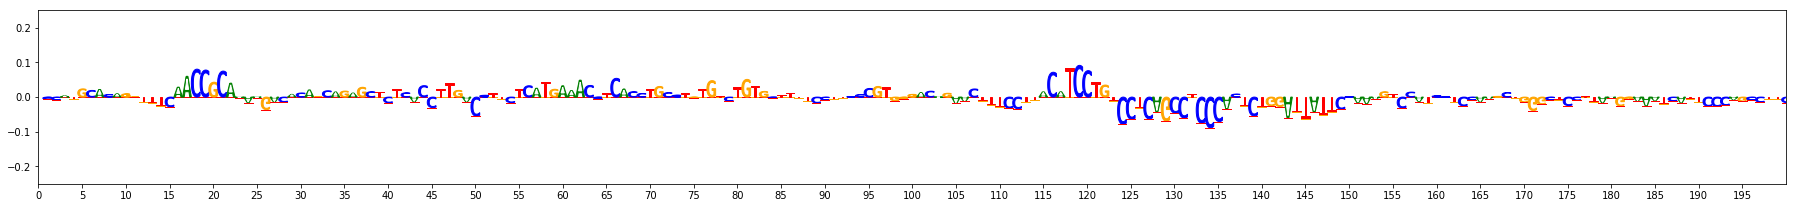

In [37]:
tmp5=dl_scores_G['SW480'][0].squeeze()[400:600]
tmp6=X['G'].squeeze()[400:600]
plot_seq_importance(tmp5,tmp6,ylim=ylim)

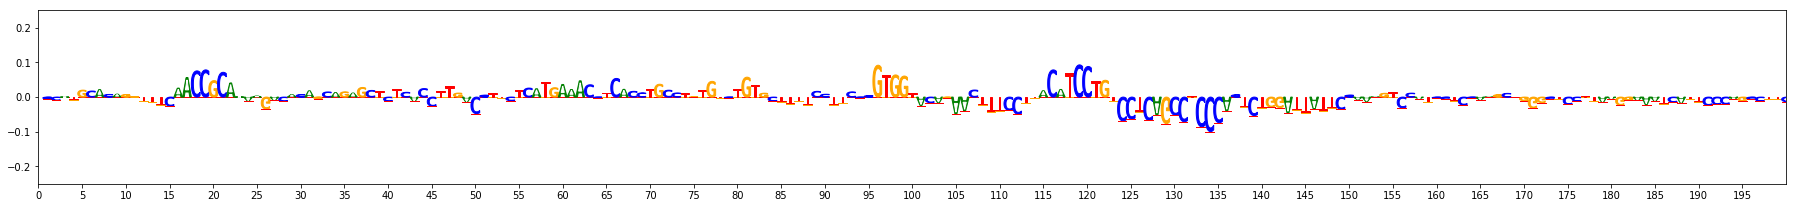

In [38]:
tmp7=dl_scores_T['SW480'][0].squeeze()[400:600]
tmp8=X['T'].squeeze()[400:600]
plot_seq_importance(tmp7,tmp8,ylim=ylim)

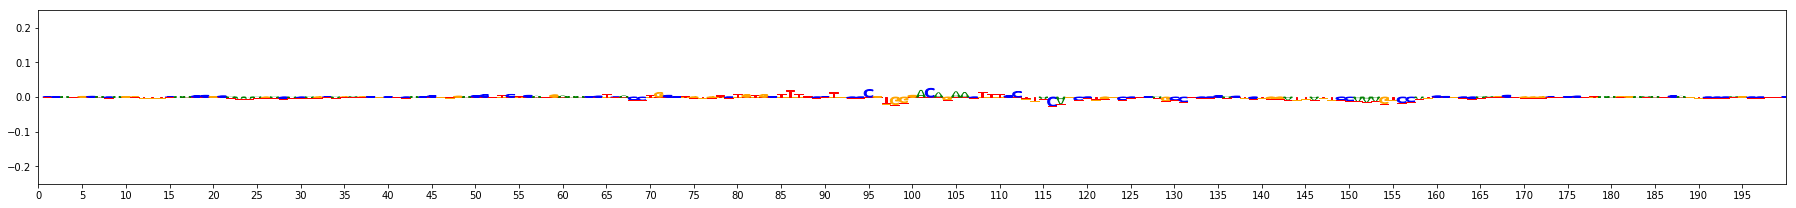

In [39]:
#delta track for the alternate G allele - reference C allele (with G at position 100)
plot_seq_importance(tmp5-tmp3,tmp6,ylim=ylim)

## COLO205

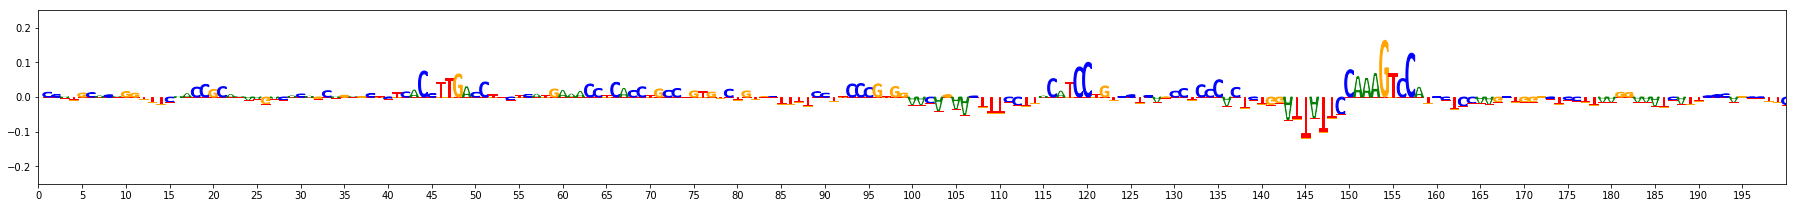

In [40]:
tmp1=dl_scores_A['COLO205'][0].squeeze()[400:600]
tmp2=X['A'].squeeze()[400:600]
plot_seq_importance(tmp1,tmp2,ylim=ylim)

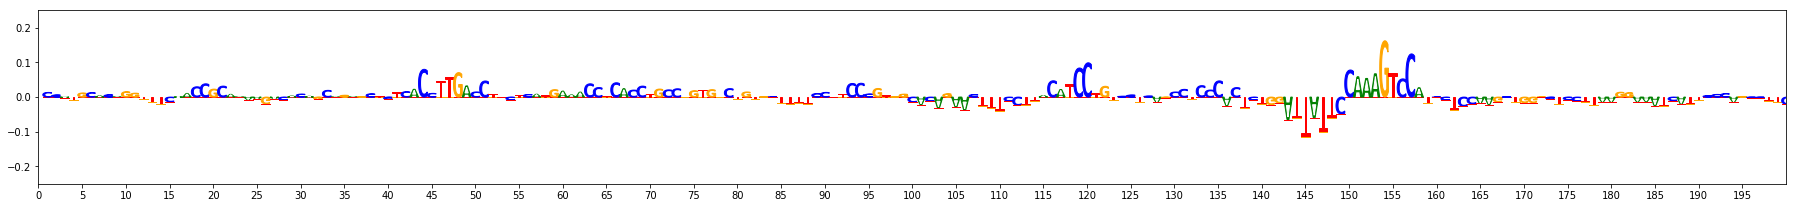

In [41]:
tmp3=dl_scores_C['COLO205'][0].squeeze()[400:600]
tmp4=X['C'].squeeze()[400:600]
plot_seq_importance(tmp3,tmp4,ylim=ylim)

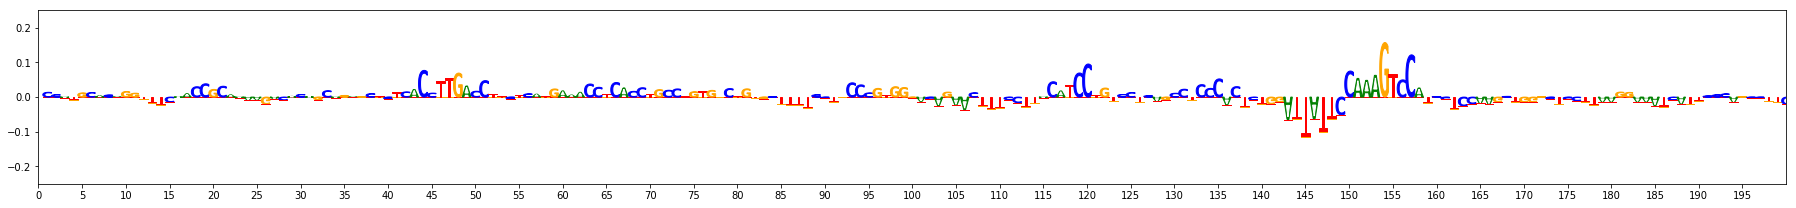

In [42]:
tmp5=dl_scores_G['COLO205'][0].squeeze()[400:600]
tmp6=X['G'].squeeze()[400:600]
plot_seq_importance(tmp5,tmp6,ylim=ylim)

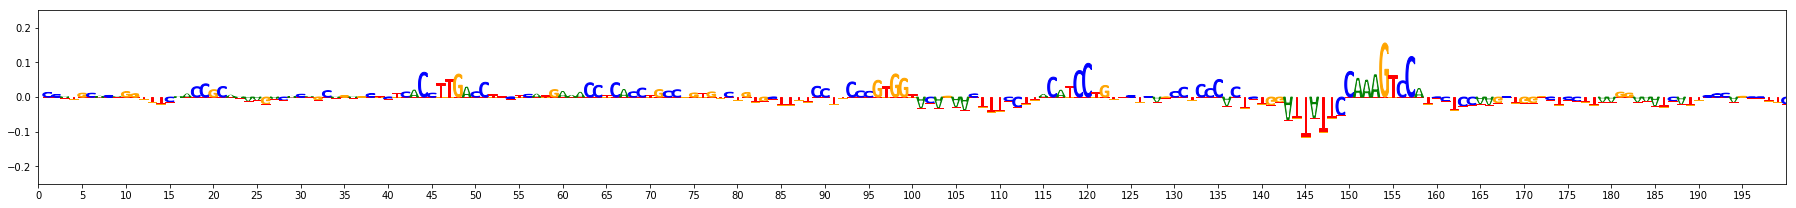

In [43]:
tmp7=dl_scores_T['COLO205'][0].squeeze()[400:600]
tmp8=X['T'].squeeze()[400:600]
plot_seq_importance(tmp7,tmp8,ylim=ylim)

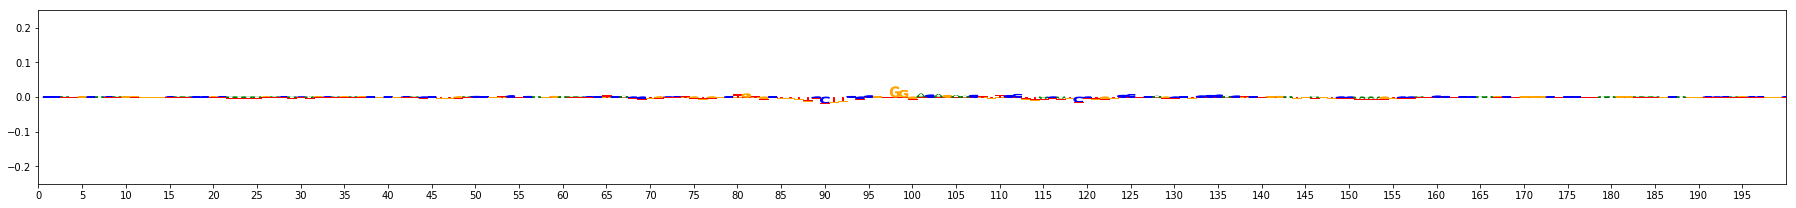

In [44]:
#delta track for the alternate G allele - reference C allele (with G at position 100)
plot_seq_importance(tmp5-tmp3,tmp6,ylim=ylim)

## HCT116

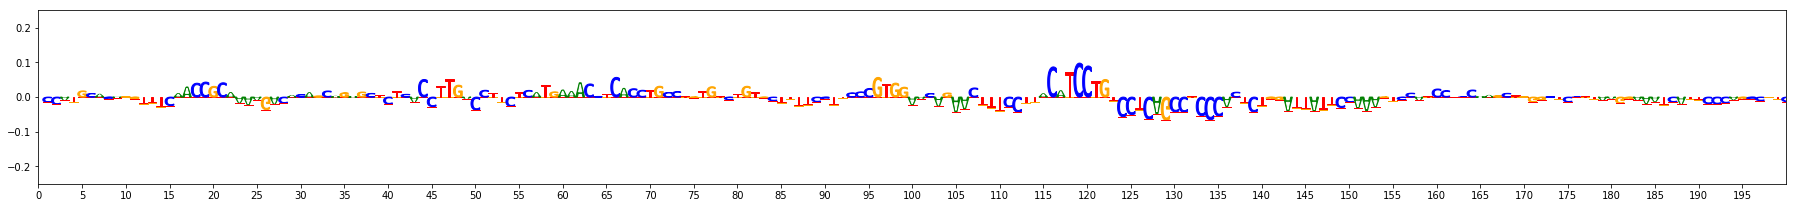

In [45]:
tmp1=dl_scores_A['HCT116'][0].squeeze()[400:600]
tmp2=X['A'].squeeze()[400:600]
plot_seq_importance(tmp1,tmp2,ylim=ylim)

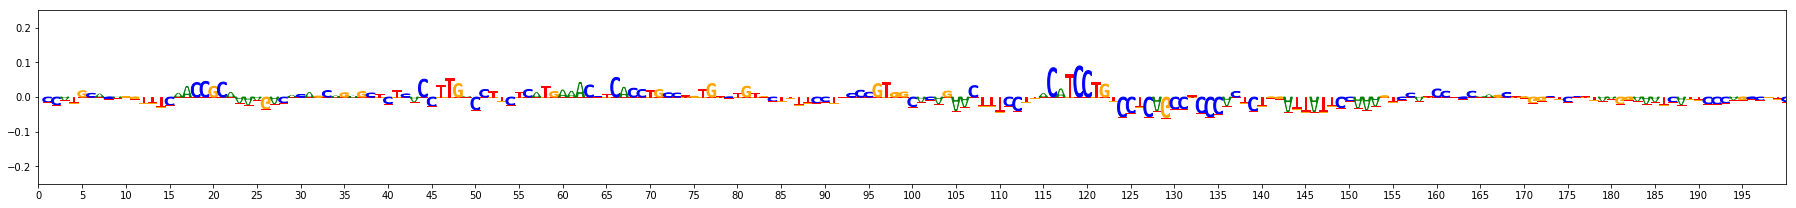

In [46]:
tmp3=dl_scores_C['HCT116'][0].squeeze()[400:600]
tmp4=X['C'].squeeze()[400:600]
plot_seq_importance(tmp3,tmp4,ylim=ylim)

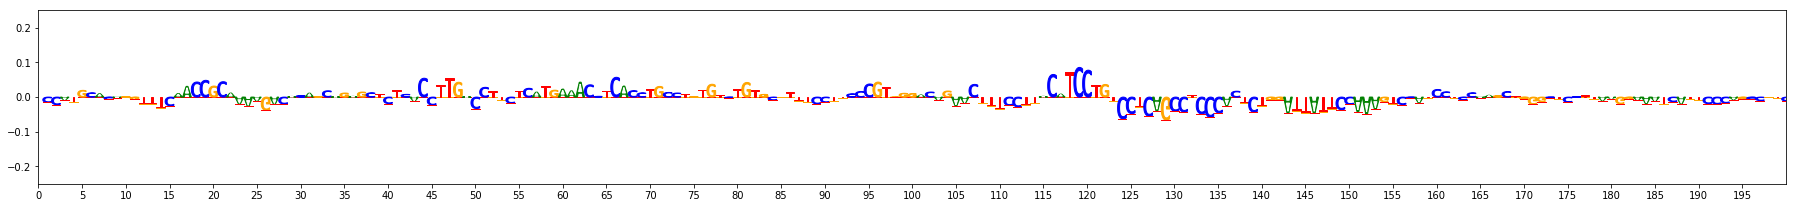

In [47]:
tmp5=dl_scores_G['HCT116'][0].squeeze()[400:600]
tmp6=X['G'].squeeze()[400:600]
plot_seq_importance(tmp5,tmp6,ylim=ylim)

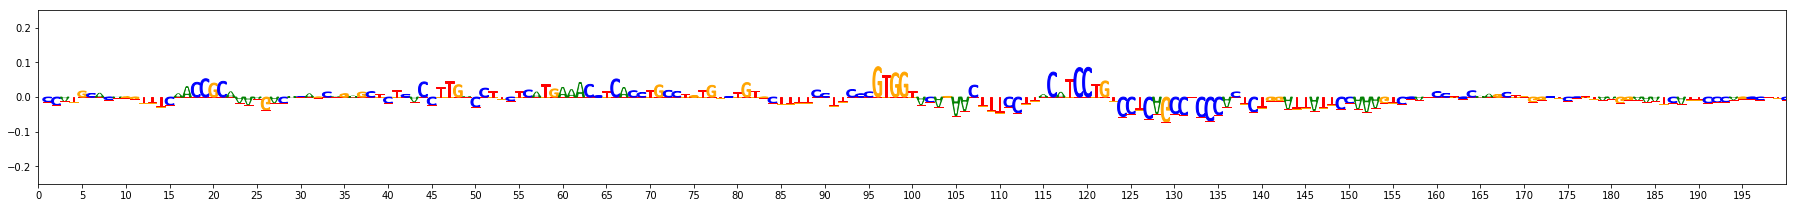

In [48]:
tmp7=dl_scores_T['HCT116'][0].squeeze()[400:600]
tmp8=X['T'].squeeze()[400:600]
plot_seq_importance(tmp7,tmp8,ylim=ylim)

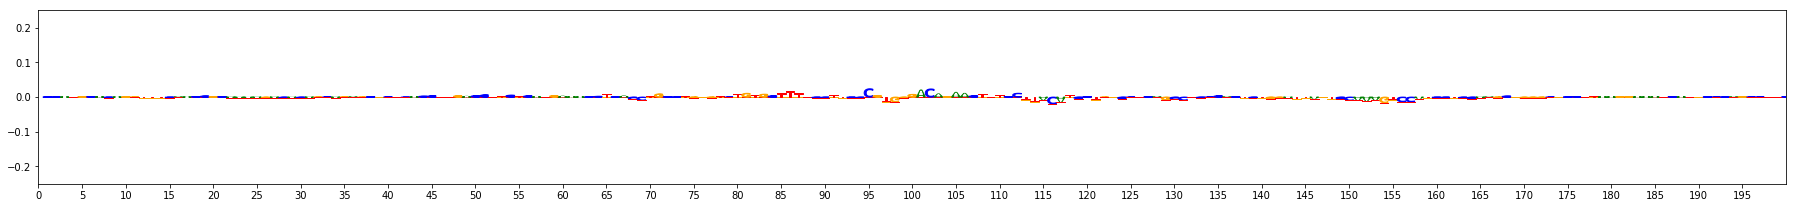

In [49]:
#delta track for the alternate G allele - reference C allele (with G at position 100)
plot_seq_importance(tmp5-tmp3,tmp6,ylim=ylim)

In [50]:
import pandas as pd 
mpra=pd.read_csv("/srv/scratch/annashch/gecco/20190207_Pilot_Data_Freeze_1/CC_Pilot_HCT116_SNPS_20180208.out",header=0,sep='\t')

In [51]:
mpra[mpra['SNP']==snp] #[['SNP','window','strand','allele','A.log2FC','B.log2FC']]

,Row.names,SNP,Project,window,strand,allele,haplotype,comb,A.Ctrl.Mean,A.Exp.Mean,...,B.Ctrl.Mean,B.Exp.Mean,B.log2FC,B.log2FC_SE,B.logP,B.logPadj_BH,B.logPadj_BF,LogSkew,Skew.logP,Skew.fdr
590,rs2525548_A_wC,rs2525548,CC_GWAS,center,fwd,ref,ref,rs2525548_center_fwd_ref,67.358090,91.692722,...,141.150794,110.135273,-0.356821,0.333442,0.354648,0.148956,0.000000,-0.801765,1.100634,0.340983
591,rs2525548_A_wC_RC,rs2525548,CC_GWAS,center,rev,ref,ref,rs2525548_center_rev_ref,1921.847150,9396.107711,...,2397.958497,2271.475127,-0.078806,1.050414,0.424667,0.182981,0.000000,-2.368231,5.592118,2.469247
592,rs2525548_A_wL,rs2525548,CC_GWAS,left,fwd,ref,ref,rs2525548_left_fwd_ref,621.766994,562.014129,...,699.581953,510.621760,-0.453551,0.606733,1.176009,0.648831,0.000000,-0.306791,0.246515,0.096608
593,rs2525548_A_wL_RC,rs2525548,CC_GWAS,left,rev,ref,ref,rs2525548_left_rev_ref,1216.559127,840.121587,...,978.830096,795.067445,-0.301322,0.811710,1.294144,0.732974,0.000000,0.233995,1.041581,0.326950
594,rs2525548_A_wR,rs2525548,CC_GWAS,right,fwd,ref,ref,rs2525548_right_fwd_ref,101.882869,147.302002,...,149.069817,162.651659,0.127770,0.341878,0.108513,0.040354,0.000000,-0.404374,0.656241,0.214274
595,rs2525548_A_wR_RC,rs2525548,CC_GWAS,right,rev,ref,ref,rs2525548_right_rev_ref,2396.241721,3771.873981,...,1782.835915,2839.754340,0.671557,0.883253,6.543946,5.635643,3.409769,0.016778,0.113750,0.043957


In [52]:
import pandas as pd 
mpra=pd.read_csv("/srv/scratch/annashch/gecco/20190207_Pilot_Data_Freeze_1/CC_Pilot_SW480_SNPS_20180208.out",header=0,sep='\t')

In [54]:
mpra[mpra['SNP']==snp] #[['SNP','window','strand','allele','A.log2FC','B.log2FC']]

,Row.names,SNP,Project,window,strand,allele,haplotype,comb,A.Ctrl.Mean,A.Exp.Mean,...,B.Ctrl.Mean,B.Exp.Mean,B.log2FC,B.log2FC_SE,B.logP,B.logPadj_BH,B.logPadj_BF,LogSkew,Skew.logP,Skew.fdr
590,rs2525548_A_wC,rs2525548,CC_GWAS,center,fwd,ref,ref,rs2525548_center_fwd_ref,67.358090,65.136499,...,141.150794,81.992139,-0.783492,0.332558,1.036239,0.434179,0.0,-0.736003,0.480722,0.158090
591,rs2525548_A_wC_RC,rs2525548,CC_GWAS,center,rev,ref,ref,rs2525548_center_rev_ref,1921.847150,6054.174128,...,2397.958497,2222.344012,-0.109615,1.050992,0.662179,0.233375,0.0,-1.764840,2.804218,0.585092
592,rs2525548_A_wL,rs2525548,CC_GWAS,left,fwd,ref,ref,rs2525548_left_fwd_ref,621.766994,596.568572,...,699.581953,607.704907,-0.203403,0.607633,0.387352,0.121374,0.0,-0.143898,0.261335,0.084373
593,rs2525548_A_wL_RC,rs2525548,CC_GWAS,left,rev,ref,ref,rs2525548_left_rev_ref,1216.559127,1112.555193,...,978.830096,950.721056,-0.042116,0.813224,0.105616,0.027730,0.0,0.086684,0.227050,0.071914
594,rs2525548_A_wR,rs2525548,CC_GWAS,right,fwd,ref,ref,rs2525548_right_fwd_ref,101.882869,106.183580,...,149.069817,138.645685,-0.104109,0.341746,0.086655,0.022476,0.0,-0.164461,0.033933,0.012432
595,rs2525548_A_wR_RC,rs2525548,CC_GWAS,right,rev,ref,ref,rs2525548_right_rev_ref,2396.241721,2739.941322,...,1782.835915,1901.143809,0.092612,0.882522,0.318942,0.094376,0.0,-0.100778,0.162733,0.055760
